solar cycle

from
https://ourcodingclub.github.io/tutorials/pandas-time-series/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!wget https://spdf.gsfc.nasa.gov/pub/data/omni/low_res_omni/omni2_all_years.dat

In [3]:
df = pd.read_csv("./omni2_all_years.dat",
                 delim_whitespace=True,
                 usecols=[0, 1, 2, 39, 40, 50],
                 names=["Year", "DOY", "Hour", "R", "Dst", "F10.7"])

In [4]:
df.head()

,Year,DOY,Hour,R,Dst,F10.7
0,1963,1,0,33,-6,999.9
1,1963,1,1,33,-5,999.9
2,1963,1,2,33,-5,999.9
3,1963,1,3,33,-3,999.9
4,1963,1,4,33,-3,999.9


In [5]:
df.index = pd.to_datetime(df["Year"] * 100000 + df["DOY"] * 100 + df["Hour"], format="%Y%j%H")
df = df.drop(columns=["Year", "DOY", "Hour"])

In [6]:
df = df.replace({"R":999,
                 "Dst":99999,
                 "F10.7":999.9}, np.nan)

In [7]:
print("Dataframe shape: ", df.shape)
dt = (df.index[-1] - df.index[0])
print("Number of hours between start and end dates: ", dt.total_seconds()/3600 + 1)

Dataframe shape:  (508440, 3)
Number of hours between start and end dates:  508440.0


<AxesSubplot:>

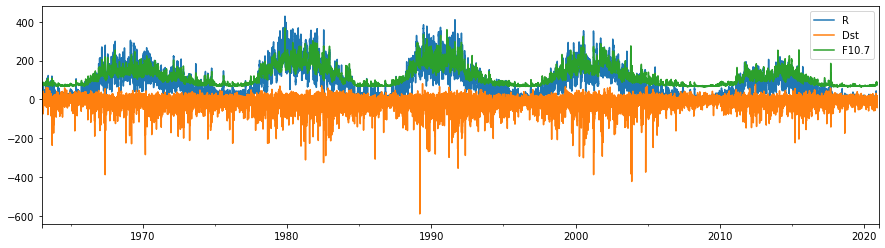

In [9]:
df.plot(figsize=(15,4))

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

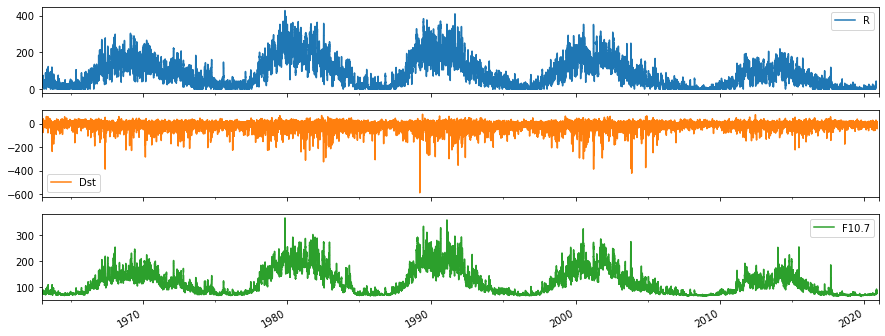

In [10]:
df.plot(subplots=True, figsize=(15,6))


<AxesSubplot:>

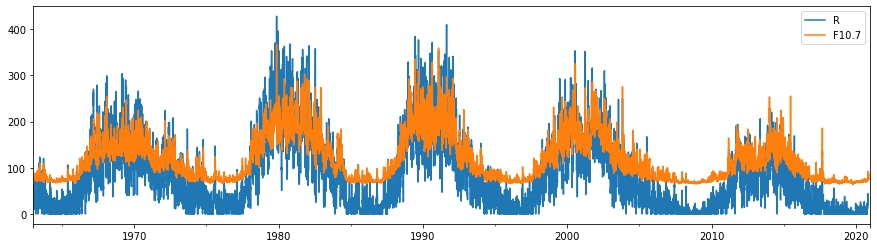

In [11]:
df.plot(y=["R", "F10.7"], figsize=(15,4))


<AxesSubplot:xlabel='R'>

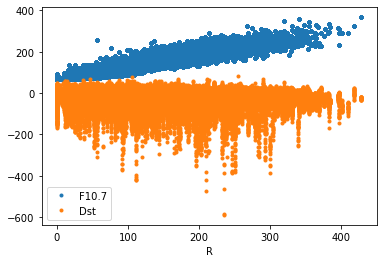

In [12]:
df.plot(x="R", y=["F10.7", "Dst"], style='.')

<AxesSubplot:>

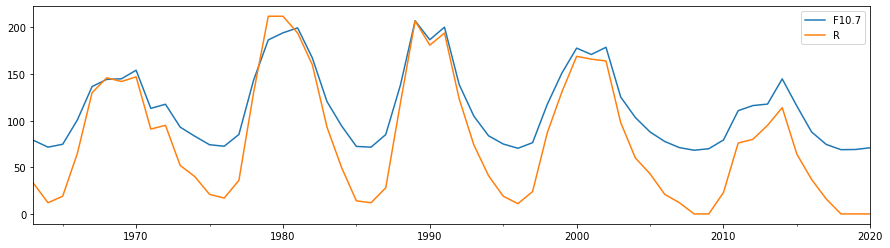

In [13]:
df[["F10.7", "R"]].resample("1y").median().plot(figsize=(15,4))


<AxesSubplot:>

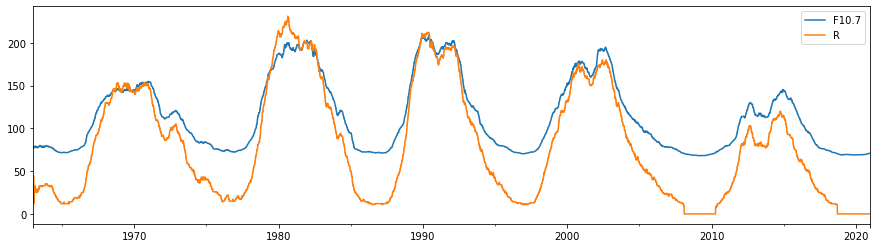

In [18]:
df[["F10.7", "R"]].rolling(24*365, min_periods=24).median().plot(figsize=(15,4))


array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

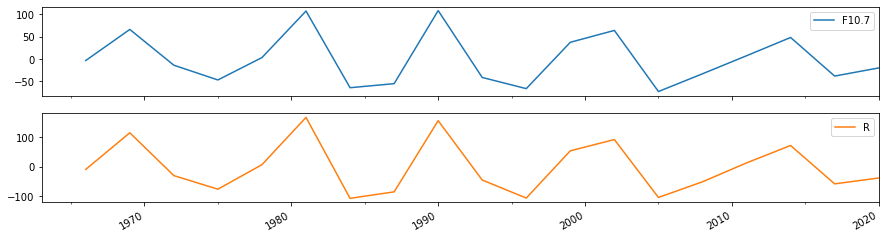

In [15]:
df[["F10.7", "R"]].resample("3y").median().diff().plot(subplots=True, figsize=(15,4))


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

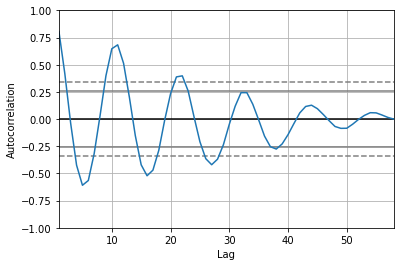

In [19]:
pd.plotting.autocorrelation_plot(df["R"].resample("1y").median())


In [20]:
Dst_count = df["Dst"].where(df["Dst"]<-100).resample("1y").count()
Dst_count = Dst_count.reindex(df.index, method="bfill")

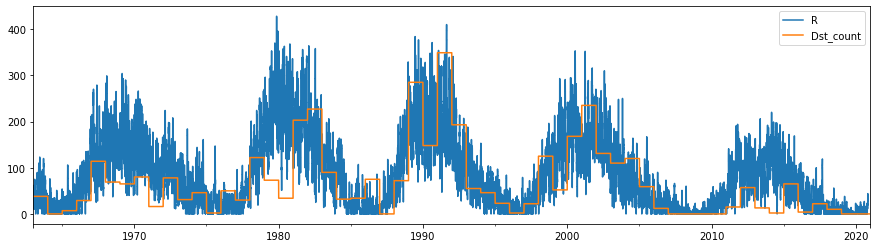

In [21]:
df["Dst_count"] = Dst_count
df.plot(y=["R", "Dst_count"], figsize=(15,4));

In [22]:
# https://en.wikipedia.org/wiki/List_of_solar_cycles
minima = ["1964-10", "1976-03", "1986-09", "1996-08", "2008-12", "2019-12"]
df_daily = df.resample("1D").mean()

def split_into_cycles(df):
    """Returns a list of dataframes, one for each solar cycle"""
    cycles = []
    # Split by solar cycle
    for start, end in zip(minima[0:-1], minima[1:]):
        cycle = df[start:end]
        # Convert from dates to days from minimum
        cycle.index = (cycle.index - cycle.index[0]).days
        # Extend so that each cycle lasts a full 5000 days (filled with nan)
        ix = pd.Int64Index(np.arange(0,5000))
        cycle.reindex(ix)
        cycles.append(cycle)
    return cycles

cycles = split_into_cycles(df_daily)


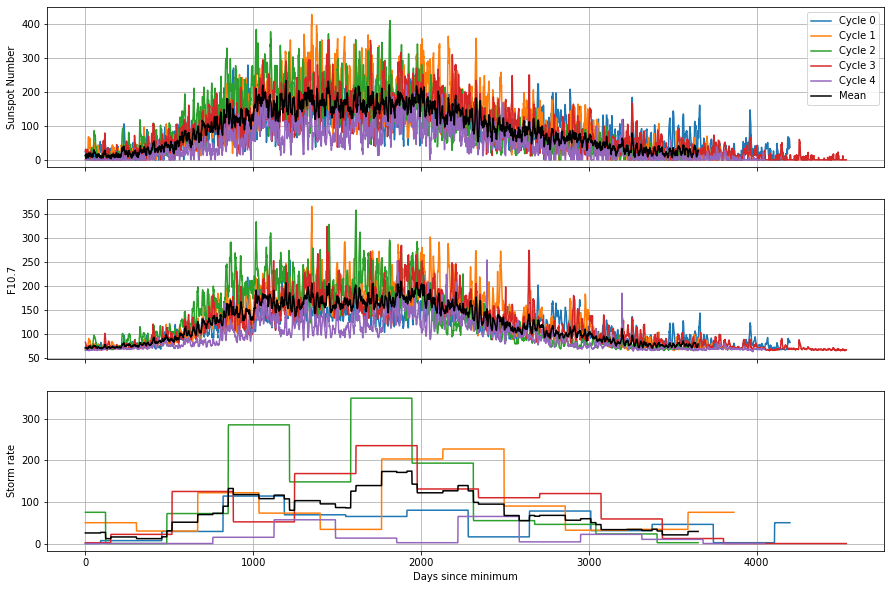

In [23]:
fig, axes = plt.subplots(3, 1, figsize=(15,10), sharex=True)
for i, cycle in enumerate(cycles):
    cycle["R"].plot(ax=axes[0], label=f"Cycle {i}")
    cycle["F10.7"].plot(ax=axes[1])
    cycle["Dst_count"].plot(ax=axes[2])
N_cycles = len(cycles)
(sum(cycles)["R"]/N_cycles).plot(ax=axes[0], color="black", label="Mean")
(sum(cycles)["F10.7"]/N_cycles).plot(ax=axes[1], color="black")
(sum(cycles)["Dst_count"]/N_cycles).plot(ax=axes[2], color="black")
axes[0].legend()
axes[0].set_ylabel("Sunspot Number")
axes[1].set_ylabel("F10.7")
axes[2].set_ylabel("Storm rate")
axes[2].set_xlabel("Days since minimum")
for ax in axes:
    ax.grid()